In [5]:
#Mendownload dataset
!gdown 1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv -O data/dataset.zip

#Melakukan unzip file dataset
!unzip -q data/dataset.zip -d data/

#Menghapus file zip
!rm -rf data/dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# klasifikasi_penyakit_tanaman_apel.py

# **Klasifikasi Penyakit Tanaman Apel Berdasarkan Citra Daun Menggunakan EfficientNet**
# Penelitian ini bertujuan untuk mengklasifikasikan penyakit tanaman apel berdasarkan citra daun dengan menggunakan beberapa varian arsitektur EfficientNet. Dataset yang digunakan berisi gambar daun dari tanaman apel yang terbagi dalam beberapa kelas, yaitu daun sehat, multiple diseases, rust, dan scab.

# 1. **Import Library dan Inisialisasi Konfigurasi**
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

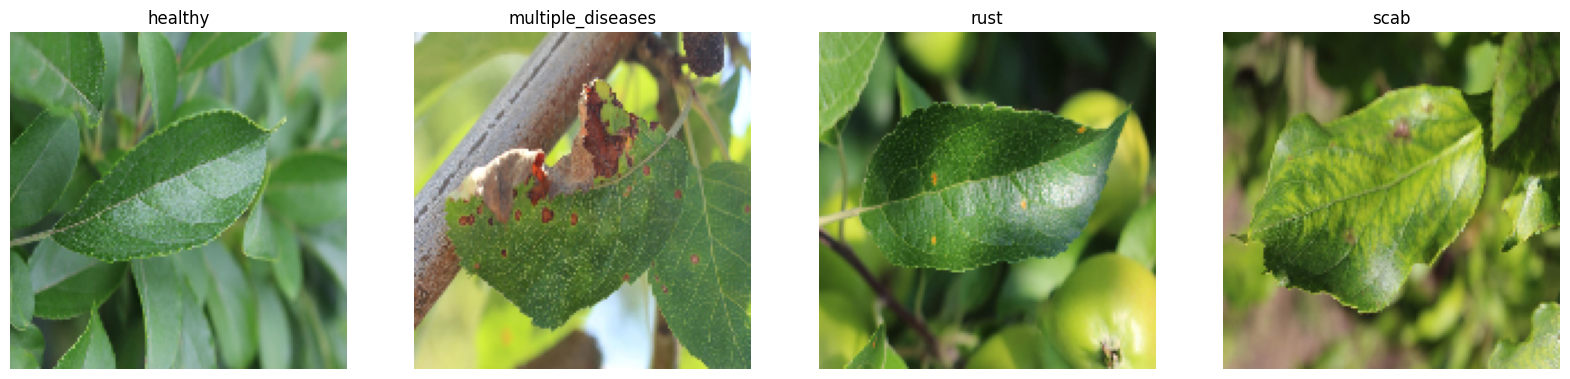

In [8]:
# 2. **Menampilkan Preview Dataset**
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Menampilkan gambar per kelas
base_path = 'data/original_dataset_utama/train'

classes = ['healthy', 'multiple_diseases', 'rust', 'scab']
fig, ax = plt.subplots(1, len(classes), figsize=(20, 5))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(base_path, class_name)
    sample_image = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, sample_image)
    img = image.load_img(img_path, target_size=(150, 150))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(class_name)

plt.show()

In [9]:
# 3. **Persiapan Dataset**
# Dataset akan dibagi menjadi 3 bagian utama: `train`, `validation`, dan `test` dengan rasio 80:10:10.
# Inisialisasi path dataset
base_path = 'data/split_train_test_dataset_utama'
train_dir = os.path.join(base_path, 'train')
validation_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')

# Membuat generator dataset
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)
validation_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_test_datagen.flow_from_directory(validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = validation_test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 1273 images belonging to 4 classes.
Found 273 images belonging to 4 classes.
Found 275 images belonging to 4 classes.


In [10]:
# 4. **Membangun Model Menggunakan EfficientNet**
# Arsitektur model EfficientNet akan digunakan untuk melakukan klasifikasi penyakit tanaman apel. Penelitian ini menggunakan varian model dari `EfficientNetB0` hingga `EfficientNetB7` serta `EfficientNetV2B0` hingga `EfficientNetV2B3`.

def build_and_compile_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
#  5. **Training dan Evaluasi Model**
# Model akan dilatih menggunakan callback `EarlyStopping` dan `ModelCheckpoint` untuk menghentikan pelatihan saat performa tidak meningkat serta menyimpan model terbaik berdasarkan akurasi pada data validasi.

# Callback
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fungsi training model
def train_and_evaluate(model, train_generator, validation_generator, test_generator, epochs=20):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )
    # Evaluasi model pada data test
    test_loss, test_acc = model.evaluate(test_generator)
    return history, test_acc

In [ ]:
# 6. **Membangun dan Melatih Model untuk Setiap Varian EfficientNet**
# Model akan dilatih untuk setiap varian `EfficientNetB0-B7` dan `EfficientNetV2B0-B3`, kemudian dilakukan evaluasi dan perbandingan performa.

# Daftar varian EfficientNet yang akan diuji
efficientnet_variants = [
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
    EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3
]

# Dictionary untuk menyimpan hasil performa
performance_results = {}

for variant in efficientnet_variants:
    model_name = variant.__name__
    print(f"Training {model_name}...")
    model = build_and_compile_model(variant, input_shape=(224, 224, 3), num_classes=train_generator.num_classes)
    _, test_acc = train_and_evaluate(model, train_generator, validation_generator, test_generator, epochs=10)
    performance_results[model_name] = test_acc

In [ ]:
# 7. **Perbandingan Performa Model**
# Setelah semua model dilatih, dilakukan perbandingan performa dengan menampilkan akurasi pada data test untuk setiap varian model.

# Menampilkan hasil performa
performance_df = pd.DataFrame(list(performance_results.items()), columns=['Model', 'Test Accuracy'])
performance_df = performance_df.sort_values(by='Test Accuracy', ascending=False)
performance_df.plot(x='Model', y='Test Accuracy', kind='bar', figsize=(12, 6), legend=False)
plt.title('Perbandingan Akurasi Model EfficientNet')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)
plt.show()